In [1]:
import torch
import torch.nn as nn
import torch.optim  as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from utils.utils import *
os.environ['KMP_DUPLICATE_LIB_OK']='True' # add this, otherwise the model will easily died because of plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

## core question:
1. given a img, which part of the image is important to class score / intermediate activation map?
2. no img, what kind of pattern will maximize the class score and activation map. 

## load data samples and pretrained model

the sample data is from cs231n course's website. and the model we load here is squeezenet which is only 3.4MB, it

In [3]:
# load samples from ImageNet
data = np.load("./imgs/imagenet_val_25.npz", allow_pickle=True)
imgs = data["X"]
labels = data["y"]
map = data["label_map"]
map = map.tolist()
print(f"sample image num: {imgs.shape[0]}")

sample image num: 25


In [3]:
# squeeze net is more efficient and more fast
model = torchvision.models.squeezenet1_1(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

## which pixel is important to class score ?

given a img and its label, we wanna show which pixel in the img is important to the class score, so we
    1. compute gradient of label with respect to input img
    2. take the max value over the RGB channel to get final output

In [17]:
def show_salency_map(input_img, label, model):
    """
    func to compute which pixel is important to class score via gradient descent.
    """
    # preprocess
    img = preprocess(input_img)
    img = img.unsqueeze(0)
    img.requires_grad = True

    # get target class score and do backprop
    model.eval()
    pred = model(img)
    class_score = pred[0, label]
    class_score.backward()
    grad_data = img.grad.data

    # convert into img format and normalize
    grad_data = grad_data.squeeze(0).permute(1,2,0)
    out, _ = torch.max(torch.abs(grad_data), dim=2)
    out = (out - out.min()) / (out.max() - out.min())

    return out


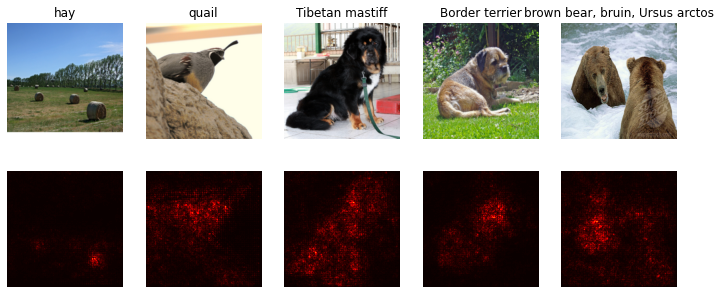

In [29]:
# plot results
for i in range(5):
  out = show_salency_map(imgs[i], labels[i], model)
  plt.subplot(2, 5, i+1)
  plt.imshow(imgs[i])
  plt.title(map[labels[i]])
  plt.axis("off")
  plt.subplot(2, 5, i+6)
  plt.imshow(out, cmap=plt.cm.hot)
  plt.axis("off")
  plt.gcf().set_size_inches(12,5)

## which pixel is important to activitation ?
again we will use gradient descent to maximize the activation map of a nouron.

## what is a hen in model's mind ?

given a target class(eg:cat) and a init random noise, we wannan do gradient descent on the noise to maximize the probabilty of the model classify the noise as a cat. to get a nature like output image, we must add some regularizar term into loss, such as the L2 norm of the output.
to get better result, here are some tricks:
1. blur the image from time to time
2. clip pixels with small value
3. clip small graident

In [16]:
blur_image = torchvision.transforms.GaussianBlur(3, sigma=0.5)

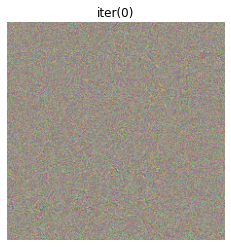

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


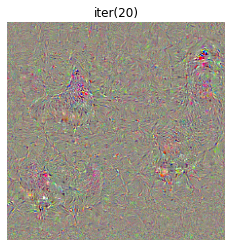

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


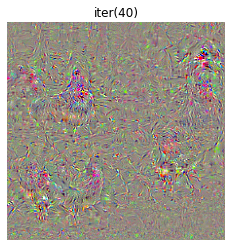

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


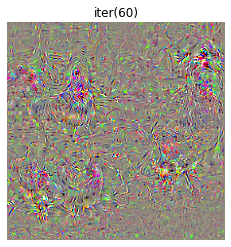

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


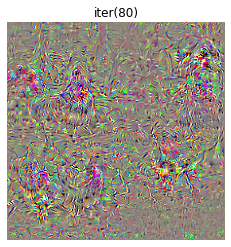

In [17]:
torch.manual_seed(3)
noise = torch.rand((1, 3, 224, 224))
tar_class = 8 # class 8 is hen
# define params
l_r = 25
l2_reg = 1e-3
num_iter = 100
# freq to blur img and show result
blur_every = 10
show_every = 20

# img is the final output
img = noise.clone()

for i in range(num_iter):
    # compute gradient
    model.eval()
    noise.requires_grad = True
    pred = model(noise)
    loss = pred[0,tar_class] - l2_reg * torch.sum(noise ** 2)
    loss.backward()
    grad_data = noise.grad.data

    # we wanna maximize class score, so do + instead of -
    img += l_r * grad_data / grad_data.norm()
    noise.grad.data.zero_()

    # clip value
    for c in range(3):
      low = float(- mean[c] / std[c])
      high = float((1.0 - mean[c])/ std[c])
      img[:, c].clamp_(min=low, max=high)

    # blur img
    if i % blur_every == 0:
      img = blur_image(img)

    # clone the img, we use img as output, use noise as input
    noise = img.clone()


    if i % show_every == 0:
        plt.imshow(img.squeeze(0).permute(1,2,0).numpy() * std + mean)
        plt.axis("off")
        plt.title(f"iter({i})")
        plt.gcf().set_size_inches(4,4)
        plt.show()